# Clustering Analysis

In this notebook we want to find out which customer groups exist. For this purpose we use the K-Means clustering method.
We are looking at three different approaches:

### Demand for each Station:
- In this part we cluster the data for each station. 

### Demand per Latitude
- In this part we cluster the data for each latitude.

### Demand for center and demand for no center
- Here we want to compare the customers from central parts of LA to customers outside the center of LA.


### Importing the datasets and the required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans

la_2018_set = pd.read_pickle("Data/la_2018_set.pickle")
feature_set = pd.read_pickle("Data/feature_set.pickle")
feature_set_daily = pd.read_pickle("Data/feature_set_daily.pickle")
la_2018_extension = pd.read_pickle("Data/la_2018_extension.pickle")

In [3]:
k_max = 10  # more than 10 clusters are definitely
            # not reasonable!

In [4]:
la_2018_set.head()

,start_time,end_time,start_station,end_station,bike_id,user_type,hour,week_day,day,month,trip_id,duration,start_coordinates,end_coordinates,distance,km/h,bike_type
0,2018-01-01 00:04:00,2018-01-01 00:25:00,3063,3018,5889,Walk-up,0,0,01/01/2018,1,65406367,21,"(34.0492, -118.2528)","(34.0437, -118.2601)",0.91,2.6,standard
1,2018-01-01 00:05:00,2018-01-01 00:25:00,3063,3018,6311,Walk-up,0,0,01/01/2018,1,65406366,20,"(34.0492, -118.2528)","(34.0437, -118.2601)",0.91,2.7,standard
2,2018-01-01 00:06:00,2018-01-01 00:25:00,3063,3018,5753,Walk-up,0,0,01/01/2018,1,65406365,19,"(34.0492, -118.2528)","(34.0437, -118.2601)",0.91,2.9,standard
3,2018-01-01 00:13:00,2018-01-01 00:35:00,3018,3031,6220,Monthly Pass,0,0,01/01/2018,1,65406364,22,"(34.0437, -118.2601)","(34.0447, -118.2524)",0.72,2.0,standard
4,2018-01-01 00:14:00,2018-01-01 00:59:00,4204,4216,12436,Monthly Pass,0,0,01/01/2018,1,65406362,45,"(33.9884, -118.4516)","(34.0234, -118.4796)",4.67,6.2,standard


## Demand for each Station 

In a first step we need to transform the station numbers into a range from zero to #Stations to get better results and a better visualisability. 

In [5]:
#la_2018_set.drop(columns =["day"], axis=1)
hour_set= pd.DataFrame()
hour_set["hour"]= la_2018_set["hour"]
hour_set["duration"]= la_2018_set["duration"]
hour_set["station"]= la_2018_set["start_station"]
hour_set.head()

,hour,duration,station
0,0,21,3063
1,0,20,3063
2,0,19,3063
3,0,22,3018
4,0,45,4204


In [6]:
transf= pd.DataFrame()
transf["station"]=hour_set["station"]
transf["hour"]=hour_set["hour"]
transf.head()
transf=pd.DataFrame(transf.groupby(["station"]).sum())
transf= transf.reset_index()
transf["index"]= list(range(132))
transf=transf.drop(columns =["hour"], axis=1)
transf.head()

,station,index
0,3000,0
1,3005,1
2,3006,2
3,3007,3
4,3008,4


In [7]:
feature_set = pd.DataFrame(hour_set.join(transf.set_index ("station"), on="station", how="left"))
feature_set=feature_set.drop(columns =["station"], axis=1)
feature_set.rename(columns = {'index':'station'}, inplace = True)
feature_set.head()

,hour,duration,station
0,0,21,45
1,0,20,45
2,0,19,45
3,0,22,10
4,0,45,105


Now, we compute the loss for different numbers of clusters:

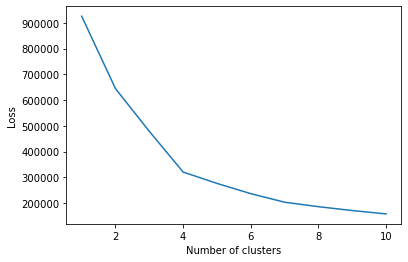

(0.0, 6.0)

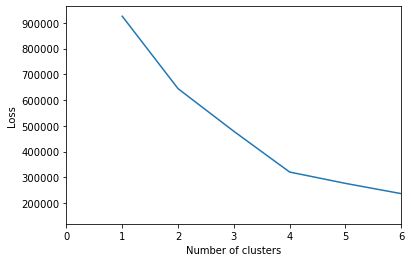

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(feature_set)
X_scaled = scaler.transform(feature_set)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_set.columns, index=feature_set.index)
X_scaled_df.head()

k_max=10
clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)
    
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,6])

We oberve that the number of clusters must be 4 due to the "elbow" in the loss curve.

In [9]:
# refit algorithm with 4 clusters
two_means = KMeans(n_clusters=4)
two_means.fit(X_scaled)

# match records to clusters by calling predict
two_means.predict(X_scaled)

array([2, 2, 2, ..., 0, 1, 1], dtype=int32)

In [10]:
feature_set.head()

,hour,duration,station
0,0,21,45
1,0,20,45
2,0,19,45
3,0,22,10
4,0,45,105


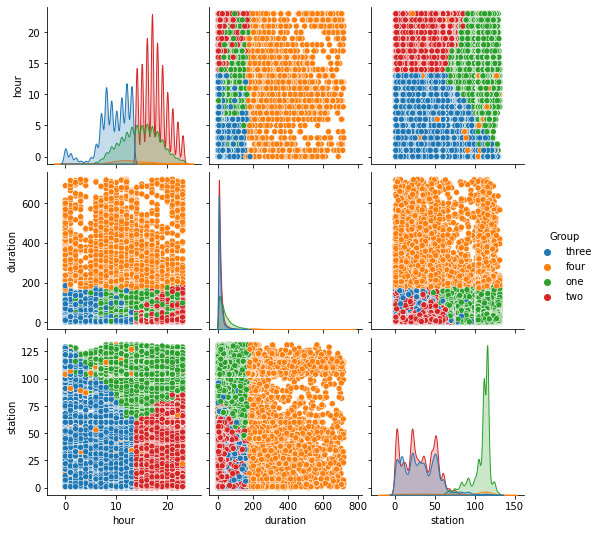

In [11]:
# Visualize the clusters in pairplot
numbers = [ "one", "two", "three", "four"]

feature_set["Group"] = two_means.predict(X_scaled)
feature_set["Group"] = feature_set["Group"].apply(lambda x: numbers[x])
sns.pairplot(data=feature_set, hue="Group")

We can see that group 4 can be clearly characterised as a group of customers which drive many hours. Group 1, 2 and 3 drive less than 3 hours whereas group 2 drives more at the end of the day and group 3 more at night and in the morning. Group 1 rents bikes during the whole day.

## Demand per Latitude

Firstly, we add the latitude data to our dataframe to compare the demand geographically. 

In [12]:
feature_set.head()

,hour,duration,station,Group
0,0,21,45,three
1,0,20,45,three
2,0,19,45,three
3,0,22,10,three
4,0,45,105,three


In [13]:
la_2018_extension2 = pd.DataFrame()
la_2018_extension2["start_lat"] =la_2018_extension["start_lat"]
la_2018_extension2["trip_id"] =la_2018_extension["trip_id"]
la_2018_extension2.head()

,start_lat,trip_id
0,34.049198,65406367
1,34.049198,65406366
2,34.049198,65406365
3,34.043732,65406364
4,33.988419,65406362


In [14]:
feature_set = pd.DataFrame(la_2018_extension2.join(la_2018_set.set_index ("trip_id"), on="trip_id", how="right"))
feature_set.dropna(inplace=True)
feature_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308030 entries, 0 to 311893
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   start_lat          308030 non-null  float64       
 1   trip_id            308030 non-null  int64         
 2   start_time         308030 non-null  datetime64[ns]
 3   end_time           308030 non-null  datetime64[ns]
 4   start_station      308030 non-null  int64         
 5   end_station        308030 non-null  int64         
 6   bike_id            308030 non-null  int64         
 7   user_type          308030 non-null  object        
 8   hour               308030 non-null  int64         
 9   week_day           308030 non-null  int64         
 10  day                308030 non-null  object        
 11  month              308030 non-null  int64         
 12  duration           308030 non-null  int64         
 13  start_coordinates  308030 non-null  object  

In [15]:
feature_set2=pd.DataFrame()
feature_set2["start_lat"]= feature_set["start_lat"]
feature_set2["duration"]= feature_set["duration"]
feature_set2["hour"]= feature_set["hour"]
feature_set2.head()

,start_lat,duration,hour
0,34.049198,21,0
1,34.049198,20,0
2,34.049198,19,0
3,34.043732,22,0
4,33.988419,45,0


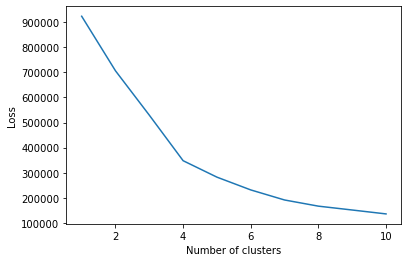

(0.0, 6.0)

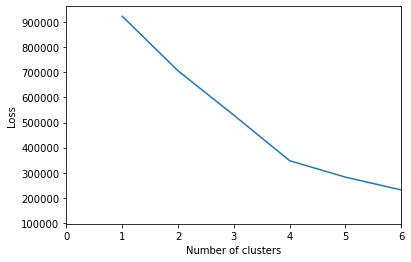

In [16]:
# Compute and visualize loss for different numbers of clusters
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(feature_set2)
X_scaled = scaler.transform(feature_set2)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_set2.columns, index=feature_set2.index)
X_scaled_df.head()

k_max=10
clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters=k+1)
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)
    
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,6])

Once again, the optimal number of clusters is 4.

In [17]:
# refit algorithm
two_means = KMeans(n_clusters=4)
two_means.fit(X_scaled)

# match records to clusters by calling predict
two_means.predict(X_scaled)

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [18]:
numbers = [ "one", "two", "three", "four"]

feature_set2["Group"] = two_means.predict(X_scaled)
feature_set2["Group"] = feature_set2["Group"].apply(lambda x: numbers[x])

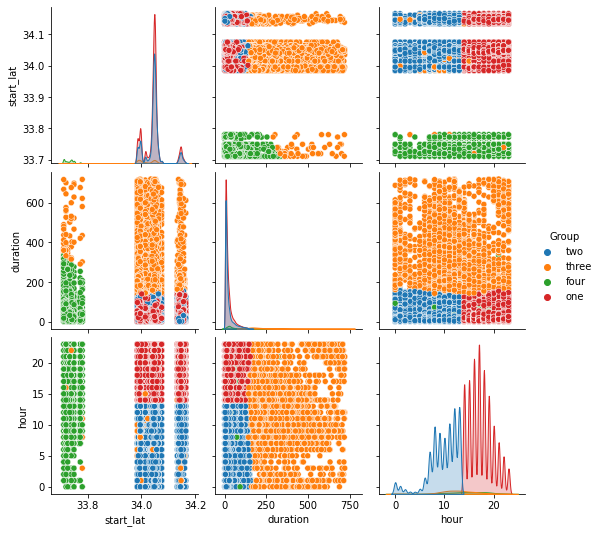

In [19]:
sns.pairplot(data=feature_set2, hue="Group")

When comparing the above results to the Heatmap visualisation in the visualisation notebook we can observe that the first "column" (mostly green dots) at the visualisation of hour and start_lat in the bottom left cell is the demand at the location "Long Beach".<br> The next "column" corresponds to "Downtown LA" and "Santa Monica" and the last "column" is "East Pasadena".<br> We observe that group 3 with the long duration customers is spread over all locations. Long Beach has in addition to group 3 only group 4 customers. The other locations have groups 1, 2 and 3. 

## Demand compared to Center

Now, we add the distinction between trips starting in central LA (i.e. "Downtown LA", "Santa Monica" and "East Pasadena") and those starting outside of central LA (i.e. "Long Beach") to the dataset.

In [20]:
feature_set2["is_center"]= feature_set2["start_lat"]
feature_set2["is_center"]= feature_set2["is_center"].apply(lambda x: 1 if x<34.15 and x>33.9 else 0)
feature_set2.head()

,start_lat,duration,hour,Group,is_center
0,34.049198,21,0,two,1
1,34.049198,20,0,two,1
2,34.049198,19,0,two,1
3,34.043732,22,0,two,1
4,33.988419,45,0,two,1


In [21]:
feature_set3 =pd.DataFrame()
feature_set3= feature_set2.copy()
feature_set3= feature_set3.drop(columns =["start_lat"], axis=1)
feature_set3.head()

,duration,hour,Group,is_center
0,21,0,two,1
1,20,0,two,1
2,19,0,two,1
3,22,0,two,1
4,45,0,two,1


/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


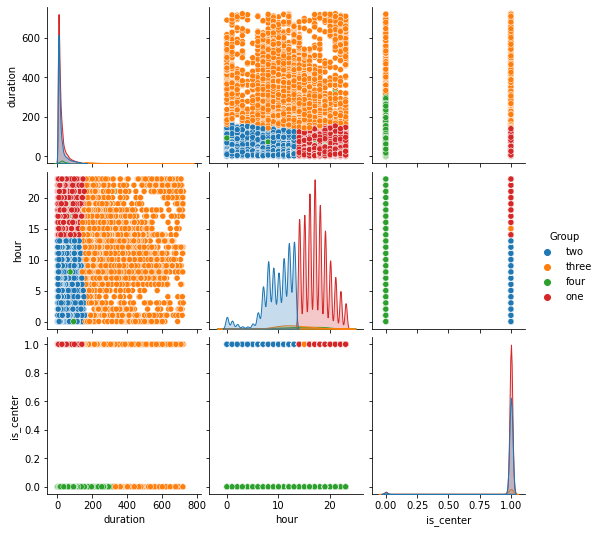

In [22]:
sns.pairplot(data=feature_set3, hue="Group")

To get a better view on the data we now look only at the data for center and no center.

## Demand for Center

In [23]:
#sort = feature_set3.sort_values("is_center", axis = 0, ascending = False)
center=pd.DataFrame()
center = feature_set3[feature_set3.is_center != 0]
center.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296567 entries, 0 to 311893
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   duration   296567 non-null  int64 
 1   hour       296567 non-null  int64 
 2   Group      296567 non-null  object
 3   is_center  296567 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 11.3+ MB


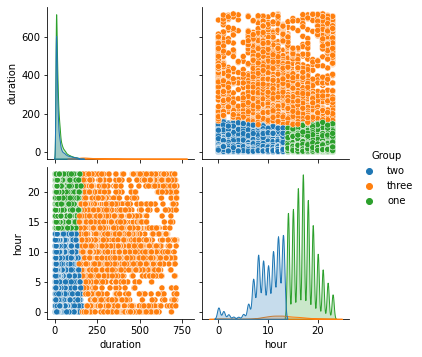

In [24]:
center= center.drop(columns =["is_center"], axis=1)
sns.pairplot(data=center, hue="Group")

In [25]:
center.mean()

duration    28.787748
hour        14.069721
dtype: float64

## Demand for No Center

In [26]:
no_center= pd.DataFrame()
no_center = feature_set3[feature_set3.is_center != 1]
no_center= no_center.drop(columns =["is_center"], axis=1)
no_center.head()

,duration,hour,Group
71,19,5,two
74,25,5,two
75,28,5,two
77,186,6,three
84,13,6,two


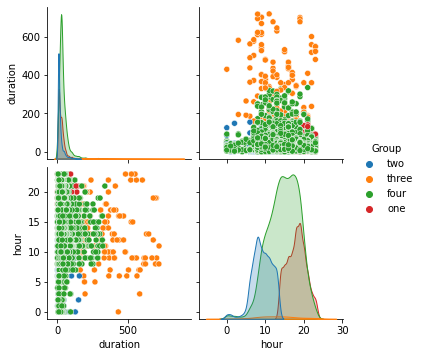

In [27]:
sns.pairplot(data=no_center, hue="Group")

In [28]:
no_center.mean()

duration    35.506150
hour        14.313618
dtype: float64

All in all, we see that the trips starting at the central regions are shorter than the trips start in Long Beach.